## Libraries

In [1]:
import os
import zipfile
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import xarray as xr
import cdsapi

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

## Load Data

In [2]:
data_path = Path(os.getcwd(), '../data')

df = pd.read_csv(data_path / 'UKHSA-2017-2022-Lyme-Disease.csv')
df

,Year,Council,Case,Population,Incidence,Lower_95CI,Upper_95CI
0,2017,Adur,1.0,63721.0,1.56934,0.03973,8.74381
1,2017,Allerdale,3.0,97213.0,3.08601,0.63641,9.01862
2,2017,Amber Valley,4.0,125898.0,3.17718,0.86567,8.13483
3,2017,Arun,9.0,158657.0,5.67262,2.59388,10.76839
4,2017,Ashfield,0.0,126164.0,0.00000,0.00000,2.92388
...,...,...,...,...,...,...,...
1805,2022,Worthing,1.0,112044.0,0.89251,0.02260,4.97273
1806,2022,Wychavon,3.0,134536.0,2.22989,0.45986,6.51668
1807,2022,Wyre,1.0,114809.0,0.87101,0.02205,4.85297
1808,2022,Wyre Forest,0.0,102328.0,0.00000,0.00000,3.60496


# Load UK Shape File

In [3]:
shap_file_path = data_path / 'Upper Tier Local Authority Boundaries/UTLA_MCTY_DEC_2022_UK_BFC.shp'

geo_data = gpd.read_file(shap_file_path)

## Get Climate Data

In [4]:
def download_uk_climate_data(years: list, output_filename: str = 'uk_climate_data.zip'):
    """
    Download UK climate data using cdsapi
    
    Parameters:
    years: list of years as strings, e.g., ['2020', '2021', '2022']
    output_filename: name for the output NetCDF file
    """
    c = cdsapi.Client()
    
    print(f"Downloading UK climate data for years: {years}")
    print("This may take several minutes...")
    
    dataset = "reanalysis-era5-single-levels"
    request = {
        "product_type": ["reanalysis"],
        "variable": [
            "2m_temperature",
            "total_precipitation"
        ],
        "year": [
            "2017", "2018", "2019",
            "2020", "2021", "2022"
        ],
        "month": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12"
        ],
        "day": ["15"],
        "time": ["12:00"],
        "area": [61, -8, 49, 2],
    }
    
    c.retrieve(dataset, request, output_filename)
    
    print(f"Download complete! Data saved as: {output_filename}")

In [5]:
# climate_data = 'uk_climate_data.zip'
# years = df['Year'].unique().astype(str).tolist()
# download_uk_climate_data(years, output_filename=climate_data)

## Extract Climate Data

In [6]:
def extract_climate_data(zip_filename: str, extract_to: str = 'climate_data'):
    """
    Extracts the contents of a zip file to a specified directory.
    
    Parameters:
    zip_filename: name of the zip file to extract
    extract_to: directory to extract files into
    """
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    
    print(f"Extracted files to: {extract_to}")

In [7]:
# output_dir = 'climate_data'
# extract_climate_data('uk_climate_data.zip', extract_to=output_dir)

## Merge Shape File with Lyme Dataset

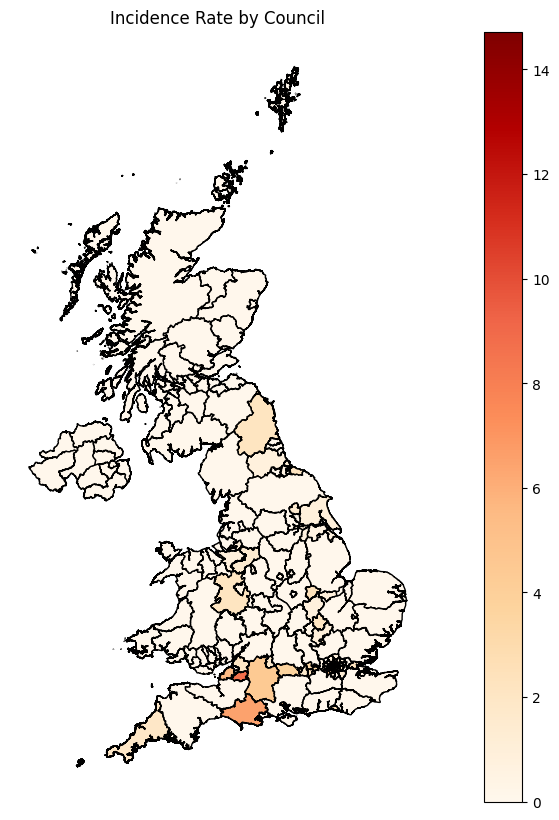

In [8]:
# Merge the shapefile with the Lyme disease data
df_shp = geo_data.merge(df, how='left', left_on='UTLA22NM', right_on='Council')
df_shp.fillna({'Incidence': 0}, inplace=True) 

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
df_shp.plot(column='Incidence', ax=ax, legend=True, cmap='OrRd', edgecolor='black')
plt.title('Incidence Rate by Council')
plt.axis('off')
plt.show()

## Load the Climate Data

In [9]:
# Load the NetCDF files
climate_data = xr.merge([xr.open_dataset('climate_data/data_stream-oper_stepType-instant.nc'),
                            xr.open_dataset('climate_data/data_stream-oper_stepType-accum.nc')])

# Extract the latitude and longitude arrays from the climate dataset
lats = climate_data.latitude.values
lons = climate_data.longitude.values

# Print available variables in the climate dataset
print("Keys (variables) in climate_data:")
print(list(climate_data.keys()))

Keys (variables) in climate_data:
['t2m', 'tp']


## Find Closest Climate Data for Our Dataset

In [10]:
# Create a function to find the closest climate data point for each geographical location
def find_closest_climate_point(row: pd.DataFrame, climate_data: xr.core.dataset.Dataset, lats: list, lons: list) -> pd.Series:
  """Find the closest climate data point for a given latitude and longitude"""
  # Calculate distance to all climate grid points
  lat_idx = np.abs(lats - row['LAT']).argmin()
  lon_idx = np.abs(lons - row['LONG']).argmin()
  
  # Get the temperature and precipitation for this point
  # Taking the mean across all time periods
  temp = float(climate_data['t2m'].sel(latitude=lats[lat_idx], longitude=lons[lon_idx]).mean().values) - 273.15  # Convert to Celsius
  precip = float(climate_data['tp'].sel(latitude=lats[lat_idx], longitude=lons[lon_idx]).mean().values) * 1000  # Convert to mm
  
  return pd.Series({'temperature': temp, 'precipitation': precip})

In [11]:
# Create a copy of the merged dataframe to avoid modifying the original
final_df = df_shp.copy()

# Apply the function to each row in the dataframe
# Only process rows that have valid coordinates
mask = (~final_df['LONG'].isna()) & (~final_df['LAT'].isna())
climate_vars = final_df[mask].apply(
  lambda row: find_closest_climate_point(row, climate_data, lats, lons),
  axis=1
)

# Join climate data back to the main dataframe
final_df.loc[mask, ['temperature', 'precipitation']] = climate_vars

# Display summary of the new dataframe
print(f"Added climate data to {mask.sum()} out of {len(final_df)} rows")
print("\nSample of final dataframe with climate data:")
final_df.head()

Added climate data to 622 out of 622 rows

Sample of final dataframe with climate data:


,UTLA22CD,UTLA22NM,UTLA22NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,Year,Council,Case,Population,Incidence,Lower_95CI,Upper_95CI,temperature,precipitation
0,E06000001,Hartlepool,None,447160,531474,-1.27018,54.6761,4b2f43f2-3cb7-46e3-9b77-6f6866ead5a0,"MULTIPOLYGON (((450154.599 525938.201, 450140....",2017.0,Hartlepool,1.0,93019.0,1.07505,0.02722,5.98979,12.112756,0.090745
1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.6761,4b2f43f2-3cb7-46e3-9b77-6f6866ead5a0,"MULTIPOLYGON (((450154.599 525938.201, 450140....",2018.0,Hartlepool,0.0,93242.0,0.00000,0.00000,3.95624,12.112756,0.090745
2,E06000001,Hartlepool,None,447160,531474,-1.27018,54.6761,4b2f43f2-3cb7-46e3-9b77-6f6866ead5a0,"MULTIPOLYGON (((450154.599 525938.201, 450140....",2019.0,Hartlepool,0.0,92401.0,0.00000,0.00000,3.99225,12.112756,0.090745
3,E06000001,Hartlepool,None,447160,531474,-1.27018,54.6761,4b2f43f2-3cb7-46e3-9b77-6f6866ead5a0,"MULTIPOLYGON (((450154.599 525938.201, 450140....",2020.0,Hartlepool,0.0,92202.0,0.00000,0.00000,4.00087,12.112756,0.090745
4,E06000001,Hartlepool,None,447160,531474,-1.27018,54.6761,4b2f43f2-3cb7-46e3-9b77-6f6866ead5a0,"MULTIPOLYGON (((450154.599 525938.201, 450140....",2021.0,Hartlepool,0.0,92575.0,0.00000,0.00000,3.98475,12.112756,0.090745


## Visualise Incidence Rate, Average Temperature and Average Precipitation

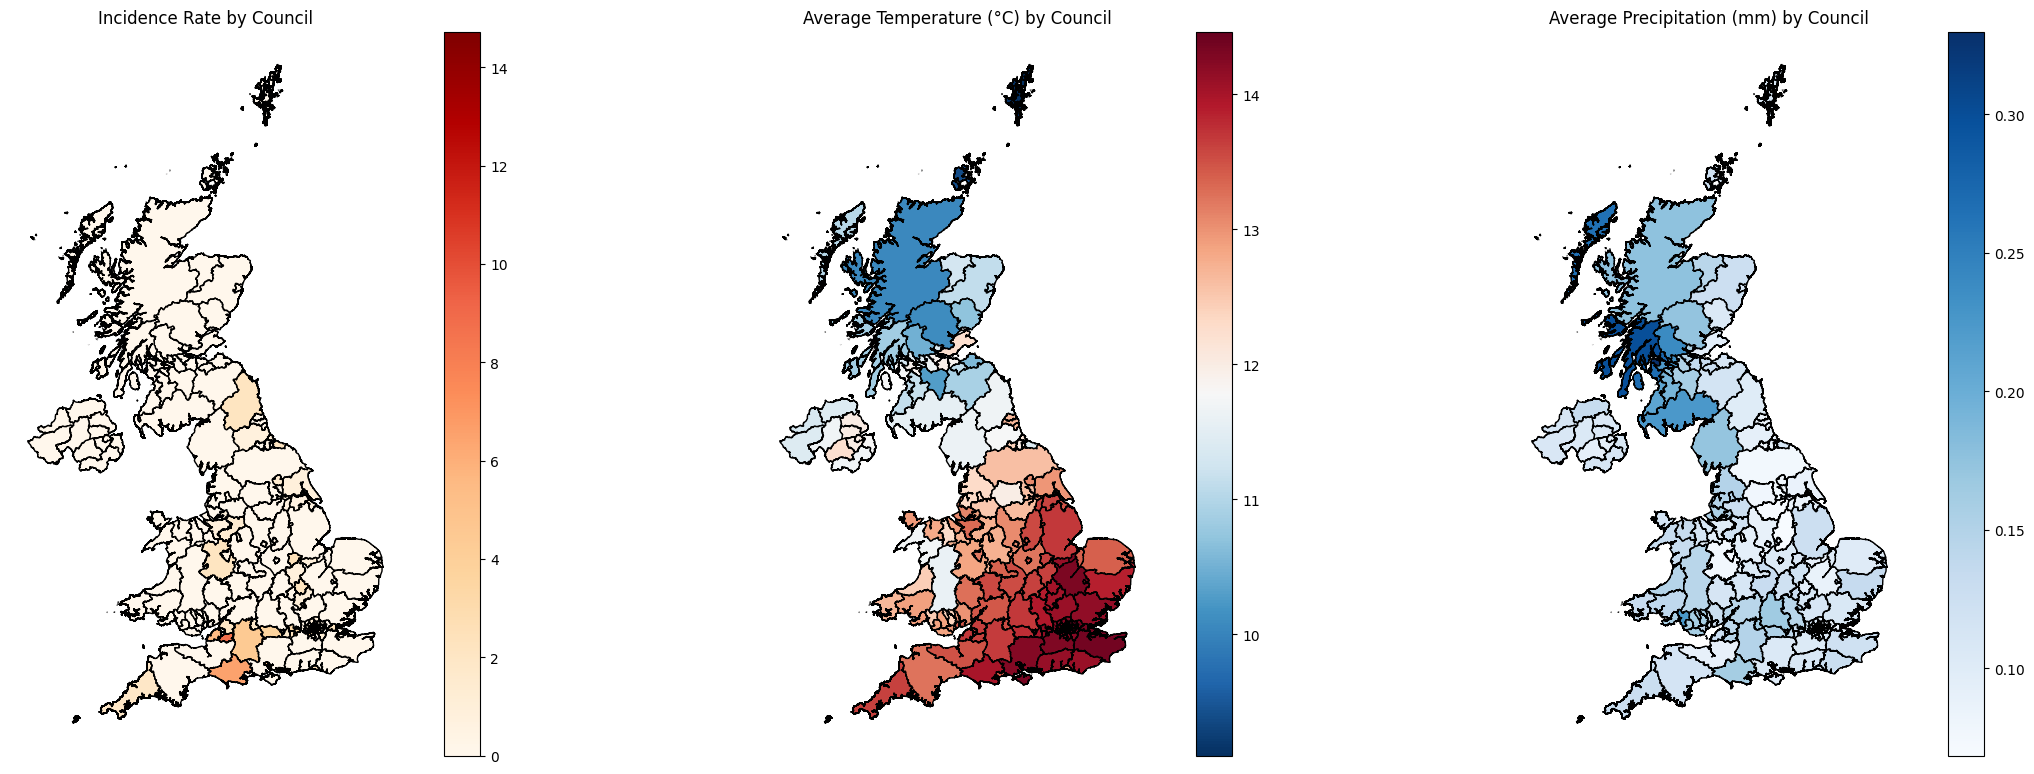

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Plot incidence rate
final_df.plot(column='Incidence', ax=axs[0], legend=True, cmap='OrRd', edgecolor='black')
axs[0].set_title('Incidence Rate by Council')
axs[0].axis('off')

# Plot temperature data
final_df.plot(column='temperature', ax=axs[1], legend=True, cmap='RdBu_r', edgecolor='black')
axs[1].set_title('Average Temperature (°C) by Council')
axs[1].axis('off')

# Plot precipitation data
final_df.plot(column='precipitation', ax=axs[2], legend=True, cmap='Blues', edgecolor='black')
axs[2].set_title('Average Precipitation (mm) by Council')
axs[2].axis('off')

plt.tight_layout()
plt.show()

## Split Training and Testing Dataset

In [20]:
train_df = final_df[final_df['Year'] < 2022]
test_df = final_df[final_df['Year'] == 2022]

c:\Users\dango\OneDrive - UWE Bristol\projects\VBD\Lyme\venv\lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\dango\OneDrive - UWE Bristol\projects\VBD\Lyme\venv\lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\dango\OneDrive - UWE Bristol\projects\VBD\Lyme\venv\lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning:

Model RMSE: 2.26
Model R² on training data: -0.04

Predictions for 2022 (sample):
                 Council  Incidence  predicted_incidence  lower_ci  upper_ci
5             Hartlepool    1.06541             0.198425       0.0  4.628645
11         Middlesbrough    0.00000             0.398721       0.0  4.828940
17  Redcar and Cleveland    2.18699             1.720789       0.0  6.151008
23      Stockton-on-Tees    0.50009             0.398721       0.0  4.828940
29            Darlington    0.00000             0.177752       0.0  4.607972


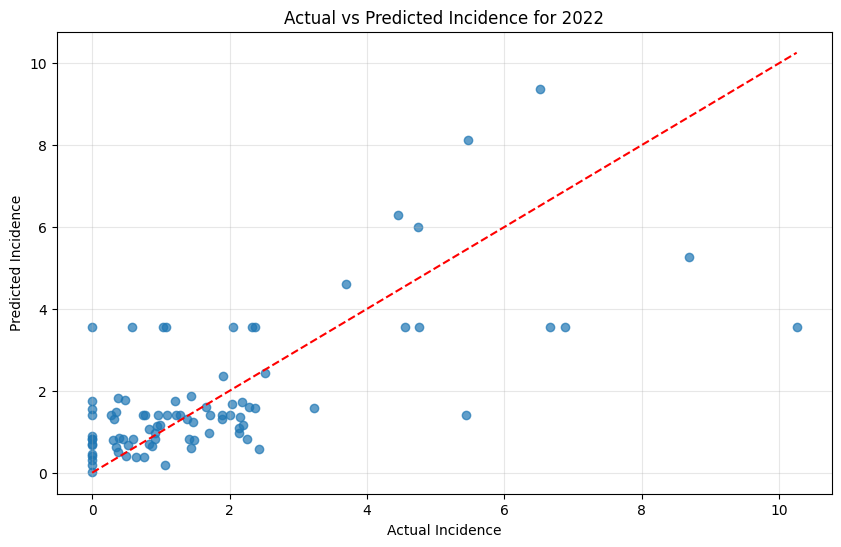

In [ ]:
# Select features and target
features = ['Case', 'Population', 'precipitation', 'temperature']
X_train = train_df[features].fillna(0)  # Handle any NaN values
y_train = train_df['Incidence'].fillna(0)
X_test = test_df[features].fillna(0)

# Create and train the random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the training data with cross-validation
cv_predictions = cross_val_predict(model, X_train, y_train, cv=5)

# Calculate prediction errors
errors = y_train - cv_predictions
rmse = np.sqrt(mean_squared_error(y_train, cv_predictions))

# Make predictions on the test data
test_df['predicted_incidence'] = model.predict(X_test)

# Add confidence intervals (based on training error distribution)
margin = 1.96 * np.std(errors)  # 95% confidence interval
test_df['lower_ci'] = np.maximum(0, test_df['predicted_incidence'] - margin)  # Incidence can't be negative
test_df['upper_ci'] = test_df['predicted_incidence'] + margin

# Print model performance metrics
print(f"Model RMSE: {rmse:.2f}")
print(f"Model R² on training data: {r2_score(y_train, cv_predictions):.2f}")

# Display prediction results
print("\nPredictions for 2022 (sample):")
test_results = test_df[['Council', 'Incidence', 'predicted_incidence', 'lower_ci', 'upper_ci']].head()
print(test_results)

# Create a scatter plot to compare actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(test_df['Incidence'], test_df['predicted_incidence'], alpha=0.7)
plt.plot([0, test_df['Incidence'].max()], [0, test_df['Incidence'].max()], 'r--')
plt.xlabel('Actual Incidence')
plt.ylabel('Predicted Incidence')
plt.title('Actual vs Predicted Incidence for 2022')
plt.grid(True, alpha=0.3)
plt.show()